In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from metpy.calc import heat_index
from metpy.units import units
from sklearn.compose import TransformedTargetRegressor
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import (
    LinearRegression,
    ElasticNet,
    LogisticRegression,
    ElasticNetCV,
)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from datetime import datetime, timedelta

from sklearn.model_selection import GridSearchCV

from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    classification_report,
    recall_score,
    precision_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

ModuleNotFoundError: No module named 'metpy'

In [3]:
def produce_time_series_data(outcome_var, level, type='daily', filename):
    df = pd.read_parquet(f"output/{filename}")
    df_weather = pd.read_parquet(f"output/nws_weather_{type}.parquet")
    df_timeseries = df.groupby(['date','year','month'])[outcome_var].sum().reset_index()\
        .merge(df_weather, on='date', how='left')
    df_timeseries['heat_index'] = df_timeseries['heat_index'].fillna(0)
    df_timeseries = df_timeseries[df_timeseries['year'] >= 2021]

    # if level=='dps':
    #     df_timeseries[outcome_var] = np.where(df_timeseries[outcome_var] > df_timeseries[outcome_var].quantile(0.95),
    #     df_timeseries[outcome_var].quantile(0.95), df_timeseries[outcome_var])
    df_timeseries = lag_outcomes_citywide(df_timeseries, [outcome_var])
    return df_timeseries
df_timeseries_ems = produce_time_series_data("ems_count", "zip", "ems_count_zip.parquet")
df_timeseries_dps = produce_time_series_data("CUSTOMERS_OUT", "dps", "outage_dps.parquet")
df_timeseries_hydrant = produce_time_series_data("count_hydrant", "tract", "hydrant_tract.parquet")

SyntaxError: parameter without a default follows parameter with a default (3824488058.py, line 1)

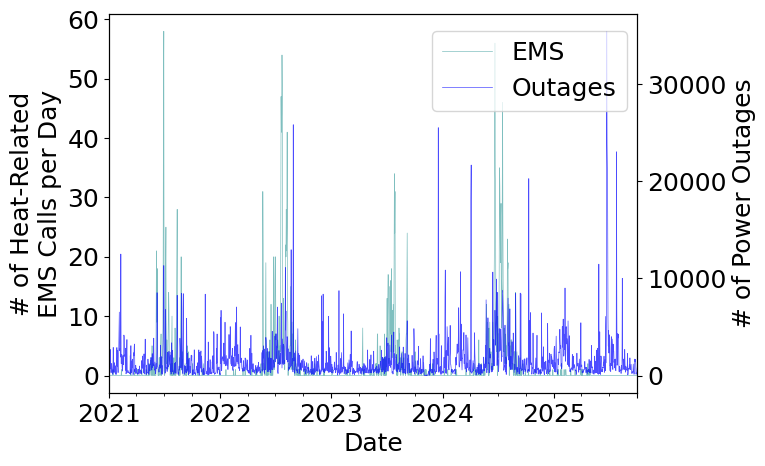

In [3]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
df_timeseries_ems.set_index('date')['ems_count'].plot(ax=ax, color='teal', alpha=0.5, linewidth=0.5, label='EMS')
ax2 = ax.twinx()
df_timeseries_dps.set_index('date')['CUSTOMERS_OUT'].plot(ax=ax2, color='blue', alpha=0.7, linewidth=0.5, label='Outages')
ax.set_ylabel('# of Heat-Related\nEMS Calls per Day')
ax2.set_ylabel('# of Power Outages')
ax.set_xlabel('Date')
plt.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.82,0.93))
plt.savefig("../figures/ems_calls_timeseries.pdf")

In [4]:
station = 'USW00094728' # STATION FOR CENTRAL PARK
df_lcds = []
for yr in range(2017,2026):
    df_lcds += [pd.read_csv(f"https://www.ncei.noaa.gov/oa/local-climatological-data/v2/access/{yr}/LCD_{station}_{yr}.csv")]
df_lcd = pd.concat(df_lcds, axis=0)
df_lcd['full_date'] = pd.to_datetime(df_lcd['DATE'])
df_lcd['date'] = pd.to_datetime(df_lcd['full_date']).dt.date
df_lcd['HourlyDryBulbTemperature'] = (df_lcd['HourlyDryBulbTemperature']*9/5) + 32
df_lcd['heat_index'] = heat_index(df_lcd['HourlyDryBulbTemperature'].values * units.degF, df_lcd['HourlyRelativeHumidity'].values * units.percent)
df_lcd = df_lcd[['STATION', 'full_date', 'date', 'heat_index']]
df_lcd_daily = df_lcd.groupby(['date'], as_index=False)['heat_index'].max().rename({'heat_index':'heat_index_mean'})


/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_28461/1893575428.py:4: DtypeWarning: Columns (64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lcds += [pd.read_csv(f"https://www.ncei.noaa.gov/oa/local-climatological-data/v2/access/{yr}/LCD_{station}_{yr}.csv")]
/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_28461/1893575428.py:4: DtypeWarning: Columns (41,64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lcds += [pd.read_csv(f"https://www.ncei.noaa.gov/oa/local-climatological-data/v2/access/{yr}/LCD_{station}_{yr}.csv")]
/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_28461/1893575428.py:4: DtypeWarning: Columns (64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lcds += [pd.read_csv(f"https://www.ncei.noaa.gov/oa/local-climatological-data/v2/access/{yr}/LCD_{station}_{yr}.csv")]
/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_28461/18

In [5]:
df_lcd_daily['date'] = pd.to_datetime(df_lcd_daily['date'])
df_timeseries_ems = df_timeseries_ems.drop(columns='heat_index').merge(df_lcd_daily, on='date', how='left')

In [6]:
df_timeseries_dps = df_timeseries_dps.drop(columns='heat_index').merge(df_lcd_daily, on='date', how='left')

In [7]:
heat_dates = df_timeseries_ems[df_timeseries_ems['nycem_heat_event']==1]['date']

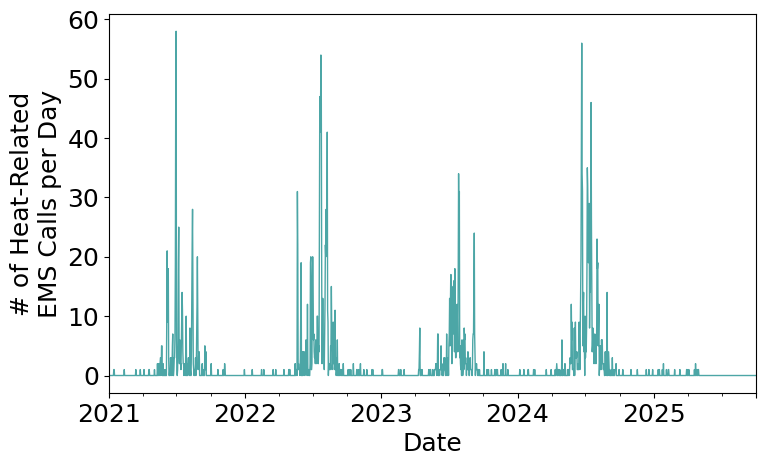

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
df_timeseries_ems.set_index('date')['ems_count'].plot(ax=ax, color='teal', alpha=0.7, linewidth=1)
plt.ylabel('# of Heat-Related\nEMS Calls per Day')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig("../figures/ems_calls_timeseries.pdf")

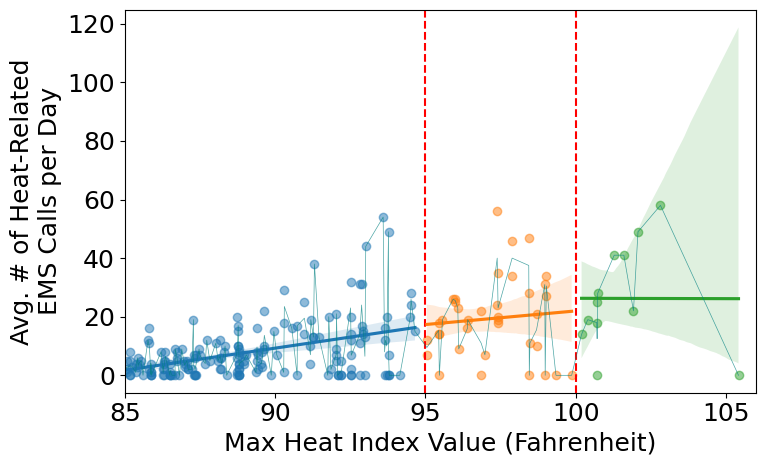

In [54]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.axvline(95, linestyle='dashed', color='red')
plt.axvline(100, linestyle='dashed', color='red')
# ax2=ax.twinx()
# df_timeseries_dps.groupby('heat_index')['CUSTOMERS_OUT'].mean().plot(ax=ax2, color='blue', alpha=0.7, linewidth=0.5)
# ax2.set_ylabel('Avg. # of Outages\nper Day')
sns.regplot(ax=ax, x='heat_index', y='ems_count', data=df_timeseries_ems[(df_timeseries_ems['heat_index']<95)&(df_timeseries_ems['heat_index']>=85)], ci=95, n_boot=1000, scatter_kws={'alpha': 0.5})
sns.regplot(ax=ax, x='heat_index', y='ems_count', data=df_timeseries_ems[(df_timeseries_ems['heat_index']>=95)&(df_timeseries_ems['heat_index']<100)], ci=95, n_boot=1000, scatter_kws={'alpha': 0.5})
sns.regplot(ax=ax, x='heat_index', y='ems_count', data=df_timeseries_ems[(df_timeseries_ems['heat_index']>=100)], ci=95, n_boot=1000, scatter_kws={'alpha': 0.5})
df_timeseries_ems.groupby('heat_index')['ems_count'].mean().plot(ax=ax, color='teal', alpha=0.7, linewidth=0.5)
ax.set_xlabel('Max Heat Index Value (Fahrenheit)')
ax.set_ylabel('Avg. # of Heat-Related\nEMS Calls per Day')
plt.xlim(85,106)
plt.tight_layout()
plt.savefig("../figures/heat_index_comparison.pdf")

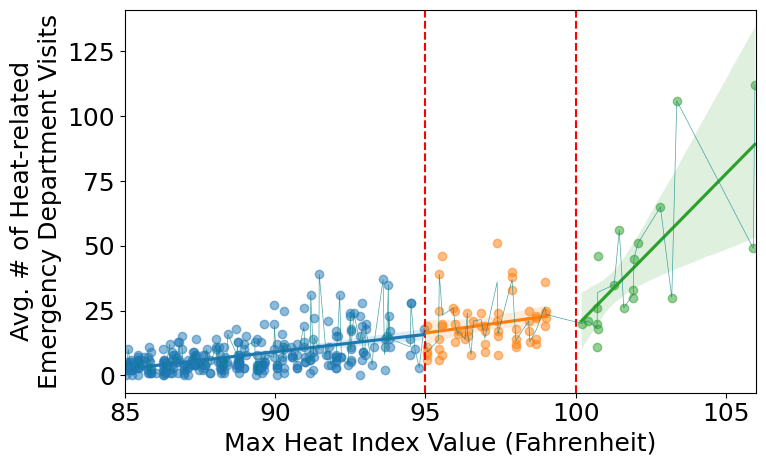

In [55]:
df_heat_stress = pd.read_csv("https://raw.githubusercontent.com/nychealth/EHDP-data/production/key-topics/heat-syndrome/previous_years.csv")
df_heat_stress['date'] = pd.to_datetime(df_heat_stress['END_DATE'])
df_heat_stress = df_heat_stress.merge(df_lcd_daily, on='date', how='left')

fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.axvline(95, linestyle='dashed', color='red')
plt.axvline(100, linestyle='dashed', color='red')
# ax2=ax.twinx()
# df_timeseries_dps.groupby('heat_index')['CUSTOMERS_OUT'].mean().plot(ax=ax2, color='blue', alpha=0.7, linewidth=0.5)
# ax2.set_ylabel('Avg. # of Outages\nper Day')
sns.regplot(ax=ax, x='heat_index', y='HEAT_ED_VISIT_COUNT', data=df_heat_stress[(df_heat_stress['heat_index']<95)&(df_heat_stress['heat_index']>85)], ci=95, n_boot=1000, scatter_kws={'alpha': 0.5})
sns.regplot(ax=ax, x='heat_index', y='HEAT_ED_VISIT_COUNT', data=df_heat_stress[(df_heat_stress['heat_index']>=95)&(df_heat_stress['heat_index']<100)], ci=95, n_boot=1000, scatter_kws={'alpha': 0.5})
sns.regplot(ax=ax, x='heat_index', y='HEAT_ED_VISIT_COUNT', data=df_heat_stress[(df_heat_stress['heat_index']>=100)], ci=95, n_boot=1000, scatter_kws={'alpha': 0.5})
df_heat_stress.groupby('heat_index')['HEAT_ED_VISIT_COUNT'].mean().plot(ax=ax, color='teal', alpha=0.7, linewidth=0.5)
ax.set_xlabel('Max Heat Index Value (Fahrenheit)')
ax.set_ylabel('Avg. # of Heat-related\nEmergency Department Visits')
plt.xlim(85,106)
plt.tight_layout()
plt.savefig("../figures/heat_stress_comparison.pdf")

# Notebook to explore using time series data at citywide level

In [15]:
def run_citywide_model(outcome_var, level, type='daily', model = 'Random Forest Regression'):
    df = pd.read_parquet(f"../data/_output/analysis_file_{level}_{type}.parquet")
    df_weather = pd.read_parquet(f"../data/_intermediate/nws_weather_{type}.parquet")
    df_timeseries = df.groupby(['date','year','month'])[outcome_var].sum().reset_index()\
        .merge(df_weather, on='date', how='left')
    df_timeseries['heat_index'] = df_timeseries['heat_index'].fillna(0)

    if level=='dps':
        df_timeseries[outcome_var] = np.where(df_timeseries[outcome_var] > df_timeseries[outcome_var].quantile(0.95),
        df_timeseries[outcome_var].quantile(0.95), df_timeseries[outcome_var])
    df_timeseries = lag_outcomes_citywide(df_timeseries, [outcome_var])
    #df_timeseries['CUSTOMERS_OUT'] = np.log(df_timeseries['CUSTOMERS_OUT']+1)
    # select covariates
    covariates = [x for x in df_timeseries.columns if (x not in [outcome_var, 'date']) and ('USW00094728' in x \
        or x in ['year', 'month', 'nycem_heat_event'] or x.endswith('lag1') or x.endswith('lag2') or x.endswith('cummean'))]

    # select test dates
    test_dates = df_timeseries[(df_timeseries['month'].isin([6,7,8])) & (df_timeseries['year']==2024)].sort_values('date')['date'].astype(str).tolist()

    df_dps_citywide = run_models(
        df_timeseries,
        outcome_var,
        [model],
        covariates,
        f'time_only_{type}',
        test_dates,
        tune=False,
        max_depth=20,
        n_estimators=500,
    )

    if model == "Random Forest Regression":
        plt.scatter(df_dps_citywide[model][test_dates[0]]['y_true'], \
        df_dps_citywide[model][test_dates[0]]['y_pred'])
        plt.ylabel('Predicted')
        plt.xlabel('True')

In [16]:
run_citywide_model('CUSTOMERS_OUT', 'dps', 'daily')

/Users/jennah/code/heat_impacts_prediction/heat_impacts_prediction/utils/utils.py:173: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_data = df.loc[(df["date"].isin(test_date))].reset_index()


################
Test date: 2024-06-01
Running model for Random Forest Regression and CUSTOMERS_OUT
Number of rows in data: (2708, 280)
(2708, 84)


NameError: name 'config' is not defined

################
Test date: 2024-06-03
Running model for Random Forest Regression and CUSTOMERS_OUT
Number of rows in data: (386, 280)
(386, 84)


/Users/jennah/code/heat_impacts_prediction/scripts/utils.py:173: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_data = df.loc[(df["date"].isin(test_date))].reset_index()


Train MAE: 256.93100090332047
Train MSE: 105605.78294856804
MAE: 911.2918793077133
MSE: 1404057.5557154822
R2: -0.9830274076824166


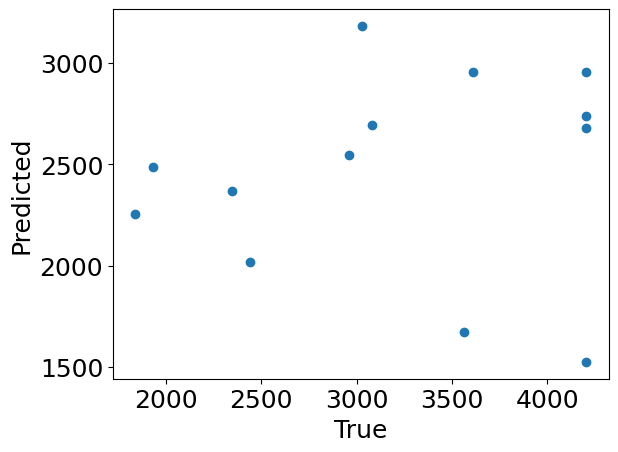

In [ ]:
run_citywide_model('CUSTOMERS_OUT', 'dps', 'weekly')

### EMS

/Users/jennah/code/heat_impacts_prediction/scripts/utils.py:173: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_data = df.loc[(df["date"].isin(test_date))].reset_index()


################
Test date: 2024-06-01
Running model for Random Forest Regression and ems_count
Number of rows in data: (1247, 280)
(1247, 84)
Train MAE: 0.3309586349379482
Train MSE: 0.6989341874549573
MAE: 3.5783454796411323
MSE: 29.754244684469807
R2: 0.7653327851091454


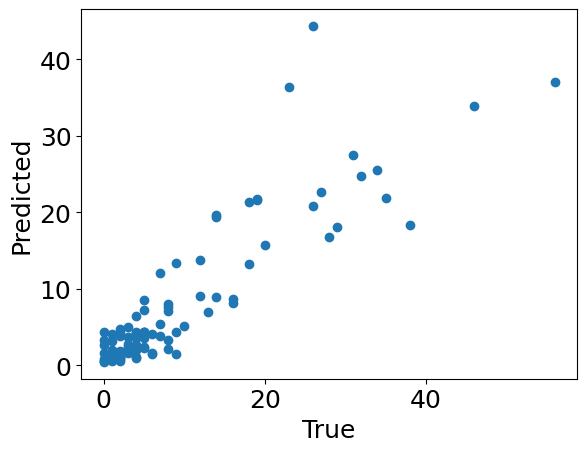

In [ ]:
run_citywide_model('ems_count', 'zip', 'daily')

################
Test date: 2024-06-03
Running model for Random Forest Regression and ems_count
Number of rows in data: (178, 280)
(178, 84)


/Users/jennah/code/heat_impacts_prediction/scripts/utils.py:173: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_data = df.loc[(df["date"].isin(test_date))].reset_index()


Train MAE: 2.3474831460674155
Train MSE: 38.102543146067426
MAE: 20.156615384615385
MSE: 1221.0502184615386
R2: 0.6303466806390015


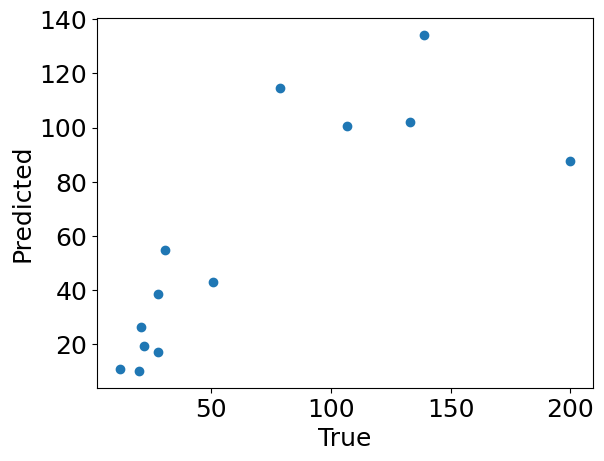

In [ ]:
run_citywide_model('ems_count', 'zip', 'weekly')

### Hydrants

In [ ]:
run_citywide_model('count_hydrant', 'tract', 'daily')

/Users/jennah/code/heat_impacts_prediction/scripts/utils.py:173: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_data = df.loc[(df["date"].isin(test_date))].reset_index()


################
Test date: 2024-06-01
Running model for Random Forest Regression and count_hydrant
Number of rows in data: (1247, 280)
(1247, 84)


NameError: name 'config' is not defined

/Users/jennah/code/heat_impacts_prediction/scripts/utils.py:173: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_data = df.loc[(df["date"].isin(test_date))].reset_index()


################
Test date: 2024-06-03
Running model for Random Forest Regression and count_hydrant
Number of rows in data: (178, 280)
(178, 84)
Train MAE: 37.944303370786514
Train MSE: 4883.801583707866
MAE: 392.5427692307693
MSE: 313834.89468861534
R2: 0.20578314235242667


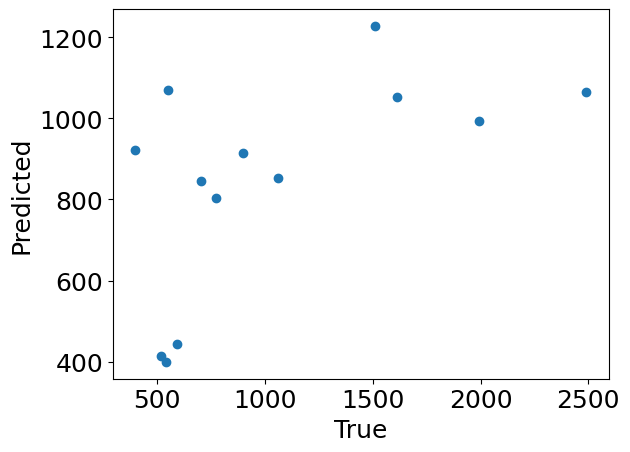

In [ ]:
run_citywide_model('count_hydrant', 'tract', 'weekly')

In [ ]:
# run_citywide_model('hydrant_bin', 'tract', type='daily', model='Random Forest Classification')

/Users/jennah/code/heat_impacts_prediction/scripts/utils.py:173: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_data = df.loc[(df["date"].isin(test_date))].reset_index()


################
Test date: 2024-06-01
Running model for Random Forest Classification and hydrant_bin
Number of rows in data: (1247, 280)
(1247, 84)


ValueError: multi_class must be in ('ovo', 'ovr')